[Get Started — Fairlearn 0.11.0.dev0 documentation](https://fairlearn.org/v0.10/quickstart.html)

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fairlearn.datasets import fetch_adult


In [113]:
data = fetch_adult(as_frame=True)
type(data)

sklearn.utils._bunch.Bunch

In [114]:
X = pd.get_dummies(data.data) # one-hot 编码
y = (data.target == '>50K') * 1 # 将 False 变为 0 ，将 True 变为 1
sex = data.data['sex']
sex.value_counts()

sex
Male      32650
Female    16192
Name: count, dtype: int64

In [118]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X, y)
y_pred = classifier.predict(X)
print(type(y_pred), y_pred)
mf = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred, sensitive_features=sex)
print(mf.overall)
# print(mf.by_group)

<class 'numpy.ndarray'> [0 0 0 ... 0 0 1]
0.8443552680070431


In [119]:
from fairlearn.metrics import selection_rate
sr = MetricFrame(metrics=selection_rate, y_true=y, y_pred=y_pred, sensitive_features=sex)
sr.overall
sr.by_group

sex
Female    0.063550
Male      0.213599
Name: selection_rate, dtype: float64

array([[<Axes: title={'center': 'accuracy'}, xlabel='sex'>,
        <Axes: title={'center': 'precision'}, xlabel='sex'>,
        <Axes: title={'center': 'false positive rate'}, xlabel='sex'>],
       [<Axes: title={'center': 'false negative rate'}, xlabel='sex'>,
        <Axes: title={'center': 'selection rate'}, xlabel='sex'>,
        <Axes: title={'center': 'count'}, xlabel='sex'>],
       [<Axes: xlabel='sex'>, <Axes: xlabel='sex'>, <Axes: xlabel='sex'>]],
      dtype=object)

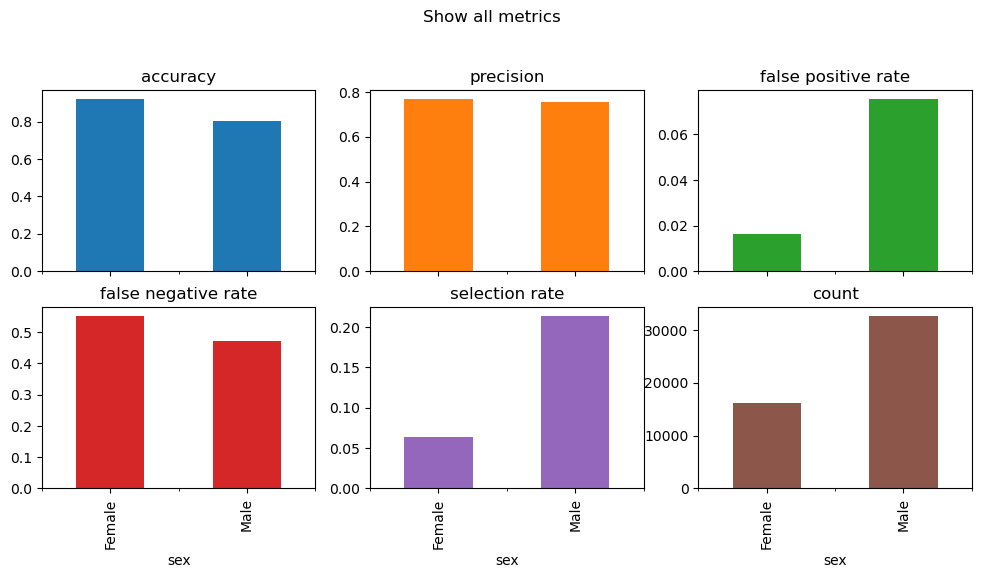

In [84]:
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import false_positive_rate, false_negative_rate, count
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y, y_pred=y_pred, sensitive_features=sex
)
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

---

# 实验部分

1. 直接使用训练好的模型

In [85]:
# 模型分割
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1, test_size=0.3, # stratify=y_true
)

In [86]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# 使用决策树
classifier = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("y_pred 的 shape 是", y_pred.shape)
print("y_test 的 shape 是", y_test.shape)
accuracy_score(y_true=y_test, y_pred=y_pred)
# mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sex)
# mf2 = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sex)
print("零的个数是", np.count_nonzero(y_pred)) # 统计非零的个数
print(mf.overall)  # 计算准确率
type(y_pred), type(y_test)

y_pred 的 shape 是 (14653,)
y_test 的 shape 是 (14653,)
零的个数是 2408
0.8443552680070431


(numpy.ndarray, pandas.core.series.Series)

In [89]:
print(type(X_test))
print(X_test.shape)
# 找到一个特定的样例为正数
for i in range(X_test.shape[0]):
    tmp = classifier.predict(X_test.iloc[[i]])
    if tmp[0] == 1: 
        break
print(i)
# print(type(classifier.predict(X_test.iloc[[0]])))
# classifier.predict(X_test.iloc[[0]])

<class 'pandas.core.frame.DataFrame'>
(14653, 105)
3


In [93]:
X_test.shape

(14653, 105)

In [107]:
# 使用可解释工具进行分析
import shap
explainer = shap.Explainer(classifier)
shap_values = explainer(X_test)
type(shap_values)
print(shap_values.shape)
# 计算 shap value

(14653, 105, 2)


In [108]:
# shap.plots.waterfall(shap_values[0])
shap_values[0]
# X_test.shape

.values =
array([[-0.00016251,  0.00016251],
       [ 0.        ,  0.        ],
       [ 0.03074093, -0.03074093],
       [ 0.0206462 , -0.0206462 ],
       [ 0.00255951, -0.00255951],
       [ 0.00418572, -0.00418572],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0

In [69]:
from sklearn.ensemble import RandomForestClassifier
# 使用随机森林
rfc = RandomForestClassifier(max_depth=5,random_state=1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
accuracy_score(y_true=y_test, y_pred=y_pred)

0.8423531017539071

In [72]:
import shap
explainer = shap.Explainer(rfc)
shap_values = explainer(X_train)
print(shap_values[0].shape)
print(shap_values[1].shape)

(105, 2)
(105, 2)


In [71]:
rfc.predict(X_test.iloc[[0]])


array([0])

In [66]:
# shap.plots.waterfall(shap_values[0])
X_test.shape

(14653, 105)

todo： 使用 Random 跑 / 使用 CF 跑
使用 shap 和 lime


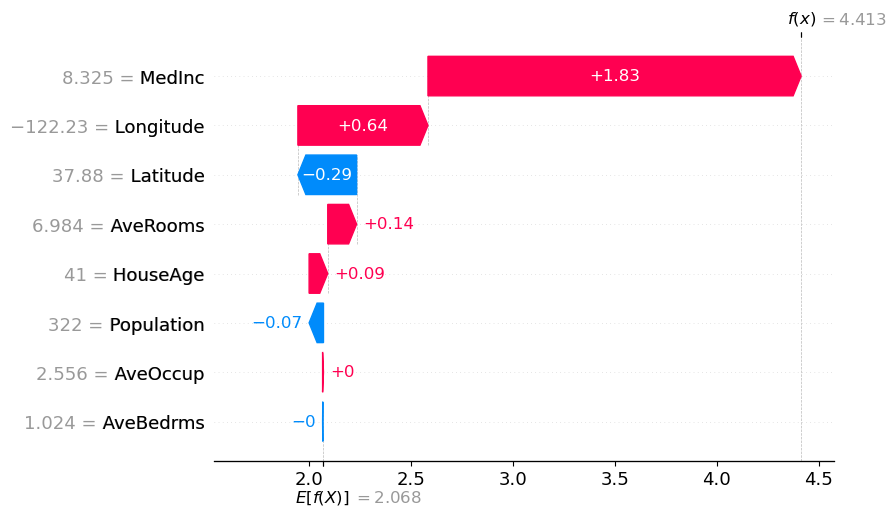

(20640, 8)


In [110]:
shap_values[0]

.values =
array([ 1.8292780e+00,  9.1367863e-02,  1.4152078e-01, -9.4358250e-04,
       -7.0454195e-02,  4.2714765e-03, -2.8787735e-01,  6.3769227e-01],
      dtype=float32)

.base_values =
2.0684466

.data =
array([   8.3252    ,   41.        ,    6.98412698,    1.02380952,
        322.        ,    2.55555556,   37.88      , -122.23      ])